# **Project 3: Hamburger/Hotdog**


## **Import the necessary libraries**

In [1]:
from PIL import Image
import pandas as pd
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


# scikit-learn modules
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Library for randomly selecting data points
import random

## **Load and Prepare the Dataset**

- Load and standardize the dataset
- Extract and encode lables. 
- Split the data into the train and the test dataset.

In [2]:
# Function to Load Images and Labels
# This function walks through the directory structure, loads the images, converts them into a consistent format,
# resizes them as needed and extracts labels from the directory names:

def load_images_from_folder(folder, count, img_size=(256, 256)):
    images = []
    for idx, filename in enumerate(os.listdir(folder)):
        if idx >= count:  # Only load up to 'count' images
            break
        if filename.endswith('.jpg'):  
            img_path = os.path.join(folder, filename)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert to RGB
                img = img.resize(img_size)  # Resize the image
                images.append(np.array(img))
    return np.array(images)


In [7]:
# Load Images and Create Labels
hotdog_folder = '/Users/jenniferleone/Desktop/AI_Bootcamp/Project 3/Images/HOTDOG'
hamburger_folder = '/Users/jenniferleone/Desktop/AI_Bootcamp/Project 3/Images/HAMBURGER'

# Load images
hotdog_images = load_images_from_folder(hotdog_folder, 500)
hamburger_images = load_images_from_folder(hamburger_folder, 500)

# Create labels (zeros and ones for the hotdog and notdog images)
hotdog_labels = np.ones(len(hotdog_images))
hamburger_labels = np.zeros(len(hamburger_images))

# Combine images and labels
X = np.concatenate((hotdog_images, hamburger_images), axis=0)
y = np.concatenate((hotdog_labels, hamburger_labels), axis=0)


In [8]:
print(len(hamburger_images))
print(len(hotdog_images))  

500
500


In [9]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

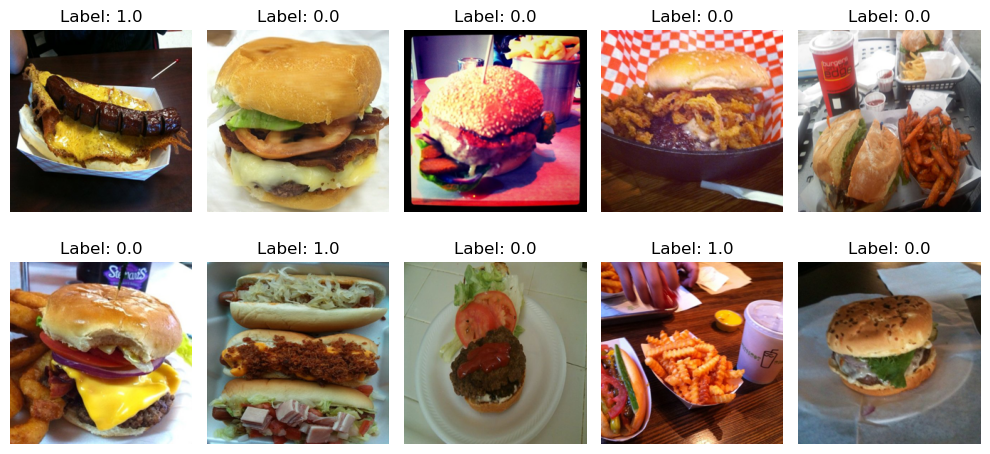

In [10]:
# Visualize the first 10 images in the dataset and printing their classification labels

def plot_images(images, labels, num_images=10):
    # Set up the figure size in inches
    plt.figure(figsize=(10, 5))
    
    for i in range(num_images):
        # Create a subplot for each image
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')  # Turn off axis numbering
        
    plt.tight_layout()
    plt.show()

plot_images(X_train, y_train)


## **Data preparation**
- Normalize the train and the test dataset by dividing by 255.

In [11]:
# Normalizing the image pixel inputs
X_train = X_train / 255.0
X_test = X_test / 255.0

In [12]:
# Displaying the first normalized training image
print('Test Dataset:', X_test.shape, y_test.shape)
print('Training Dataset:', X_train.shape, y_train.shape)

Test Dataset: (200, 256, 256, 3) (200,)
Training Dataset: (800, 256, 256, 3) (800,)


In [13]:
# Displaying the first normalized testing image and its pixel values
print("Shape of the first normalized testing image:", X_test[0].shape)
print("Pixel values of the first normalized testing image:")
print(X_test[0])

Shape of the first normalized testing image: (256, 256, 3)
Pixel values of the first normalized testing image:
[[[0.78431373 0.53333333 0.69803922]
  [0.78039216 0.53333333 0.69411765]
  [0.77254902 0.54117647 0.69411765]
  ...
  [0.96470588 0.95294118 0.9254902 ]
  [0.96862745 0.95686275 0.9254902 ]
  [0.96862745 0.95686275 0.9254902 ]]

 [[0.78823529 0.57254902 0.7254902 ]
  [0.78823529 0.58039216 0.72941176]
  [0.78431373 0.58039216 0.72156863]
  ...
  [0.96078431 0.94117647 0.90588235]
  [0.96470588 0.94509804 0.90588235]
  [0.96470588 0.94509804 0.90196078]]

 [[0.78039216 0.62352941 0.75686275]
  [0.78431373 0.62352941 0.75294118]
  [0.78823529 0.62352941 0.74901961]
  ...
  [0.95686275 0.91764706 0.85882353]
  [0.96078431 0.92156863 0.8627451 ]
  [0.96078431 0.9254902  0.85882353]]

 ...

 [[0.70196078 0.68235294 0.65882353]
  [0.6745098  0.65490196 0.63137255]
  [0.63921569 0.61960784 0.59607843]
  ...
  [0.86666667 0.69411765 0.31372549]
  [0.85490196 0.68627451 0.31764706]
  

## **Model Building**

---
### **CNN Model - Iteration #1**

In [14]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [15]:
# Define a CNN model
model_1 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
# Train the model
batch_size = 32
epochs = 10

model_fit = model_1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1)

In [ ]:
# Evaluating on the Test dataset
loss, accuracy = model_1.evaluate(X_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)

In [ ]:
# Accuracy and Loss Plots
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']

loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Plot Confusion Matrix

# Correctly predict using the model
y_pred = model_1.predict(X_test)

# Set the threshold for the split between 0 and 1
threshold = 0.5

# Apply the threshold to get predicted class labels
y_pred_thresh = np.where(y_pred > threshold, 1, 0)

cm = confusion_matrix(y_test, y_pred_thresh)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hotdog', 'Hotdog'], yticklabels=['Not Hotdog', 'Hotdog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Breakdown of the Metrics:
- **Training Accuracy: 98.58%**
  - This is quite high and suggests that your model has learned to classify the training data very well.
- **Training Loss: 0.0527**
  - The loss is quite low, which corroborates with the high training accuracy, indicating that your model's predictions are very close to the actual labels on the training data.
- **Validation Accuracy: 86.00%**
  - This accuracy is lower compared to the training accuracy. While it is still a reasonably good score, the noticeable drop from the training accuracy suggests that the model might not be performing as well on unseen data.
- **Validation Loss: 0.3771**
  - The validation loss is significantly higher than the training loss. This disparity is another indication that the model may be overfitting to the training data.

### Analysis:
1. **Overfitting**: The primary concern here is overfitting. The model is performing exceptionally well on the training data but not as well on the validation data. Overfitting occurs when a model learns the details and noise in the training data to an extent that it negatively impacts the performance on new data.

2. **Generalization Gap**: The difference between training and validation accuracy (and loss) is known as the generalization gap. A large gap suggests that the model's ability to generalize to unseen data could be improved.

### Potential Solutions:
- **Data Augmentation**: This technique involves randomly transforming the existing training images in ways that are likely to occur in real-world scenarios. This can include rotations, translations, scaling, flipping, etc. It helps to increase the diversity of your training data, making your model less likely to memorize the training data and more likely to generalize better.
- **Dropout**: Adding dropout layers to your network can help in reducing overfitting. Dropout layers randomly disable a fraction of neurons during training, which prevents them from co-adapting too much.
- **Early Stopping**: This technique involves stopping the training process if the validation loss starts to increase (despite improvements in training loss), which is a hallmark of overfitting.
- **Regularization Techniques**: Applying L1 or L2 regularization can also help in controlling overfitting by penalizing overly complex models.

Implementing one or more of these strategies should help improve the model's performance on unseen data. 

### **CNN Model - Iteration #2**

### Augmentation

With 500 images of "hotdog" and 500 images of "not hotdog," we have a decently sized dataset to start with, especially considering the balance between the classes. The need to augment the dataset to increase its size depends on several factors:

1. **Model Complexity**
If you are using a complex model or deep neural network, these typically require large amounts of data to generalize well without overfitting. In such cases, even a dataset of 1,000 images might be insufficient, and data augmentation could help by artificially expanding the diversity and size of your training data.

2. **Performance Goals**
Consider your performance metrics and goals. If initial training results are not satisfactory or if the model performs well on training data but poorly on validation data (a sign of overfitting), then data augmentation might be necessary to improve the model’s ability to generalize.

3. **Variability in Data**
Data augmentation is particularly useful when you need the model to be robust against variations in inputs that are not well-represented in your dataset. For example, if your "hotdog" images are all taken under similar lighting conditions or from similar angles, your model might not perform well when presented with "hotdog" images under different conditions. Augmenting data to include transformed images (e.g., different rotations, lighting conditions, and crops) can help the model learn to recognize the key features of "hotdog" and "not hotdog" under a broader range of conditions.

4. **Computational Resources**
More data typically requires more computational power and longer training times. If resources are limited, you might start with your existing dataset to see how well you can optimize the model and consider augmentation if improvements are needed and computationally feasible.



In [ ]:
# Define the data augmentation configuration


# Initialize data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Prepare training and validation data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(X_test, y_test, batch_size=32)


# Print the length of each list
print(len(X_train))
print(len(y_train))


In [ ]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define CNN model_2
model_2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Calculate steps per epoch and validation steps
steps_per_epoch = np.ceil(len(X_train) / 32)  # Ensures all samples are used
validation_steps = np.ceil(len(X_test) / 32)  # Ensures all samples are used

# Train the model
model_fit = model_2.fit(
    train_generator,
    steps_per_epoch=int(steps_per_epoch),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=int(validation_steps)
)

In [ ]:
# Evaluating on the Test dataset
loss, accuracy = model_2.evaluate(X_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)

In [ ]:
# Accuracy and Loss Plots
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']

loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Plot Confusion Matrix

# Correctly predict using the model
y_pred = model_2.predict(X_test)

# Set the threshold for the split between 0 and 1
threshold = 0.5

# Apply the threshold to get predicted class labels
y_pred_thresh = np.where(y_pred > threshold, 1, 0)

cm = confusion_matrix(y_test, y_pred_thresh)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hotdog', 'Hotdog'], yticklabels=['Not Hotdog', 'Hotdog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### **CNN Model - Iteration #3**

### Dropout
Dropout is a technique where randomly selected neurons are ignored during training, reducing the chance of overfitting. 

In [ ]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.layers import Dropout

# Define CNN model_3 with Dropout
model_3 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),  # Dropout layer
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
batch_size = 32
epochs = 10

model_fit = model_3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs, 
    batch_size=batch_size)



In [ ]:
# Evaluating on the Test dataset
loss, accuracy = model_3.evaluate(X_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)

In [ ]:
# Accuracy and Loss Plots
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']

loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Plot Confusion Matrix

# Correctly predict using the model
y_pred = model_3.predict(X_test)

# Set the threshold for the split between 0 and 1
threshold = 0.5

# Apply the threshold to get predicted class labels
y_pred_thresh = np.where(y_pred > threshold, 1, 0)

cm = confusion_matrix(y_test, y_pred_thresh)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hotdog', 'Hotdog'], yticklabels=['Not Hotdog', 'Hotdog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### **CNN Model - Iteration #4**

### Early Stopping
Early stopping is a method to stop training when the validation metric stops improving, preventing overfitting and saving computational resources.

In [ ]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define a CNN model
model_4 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Verbosity mode
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)

# Fit the model with early stopping
model_fit = model_4.fit(
    X_train, y_train,  
    validation_data=(X_test, y_test),  
    epochs=50,  
    callbacks=[early_stopping] 
)




In [ ]:
# Evaluating on the Test dataset
loss, accuracy = model_4.evaluate(X_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)

In [ ]:
# Accuracy and Loss Plots
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']

loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
